In [28]:
from dolfin import *
import matplotlib.pyplot as plt

In [29]:
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

In [30]:
# Create mesh and define function space
mesh = UnitSquareMesh(20, 20, "crossed")
V = VectorFunctionSpace(mesh, "Lagrange", 1)

In [31]:
# Mark boundary subdomains
left = CompiledSubDomain("near(x[0], side) && on_boundary", side=0.0)
right = CompiledSubDomain("near(x[0], side) && on_boundary", side=1.0)

In [13]:
# Define Dirichlet boundary values (x = 0 or x = 1)
c = Constant((0, 0))
r = Expression(("scale*(x0 + (x[0] - x0)*cos(theta) - (x[1] - y0)*sin(theta) - x[1])",
                "scale*(x0 + (x[1] - y0)*sin(theta) + (x[1] - y0)*cos(theta) - x[1])"),
                scale = 0.5, x0 = 0.5, y0 = 0.5, theta = pi/3, degree=2)

In [14]:
bcLeft = DirichletBC(V, c, left)
bcRight = DirichletBC(V, r, right)
bcs = [bcLeft, bcRight]

In [17]:
# Define functions
du = TrialFunction(V)    # incremental displacement
v = TestFunction(V)      # test function
u = Function(V)          # displacement from previous iteration
B = Constant((0.0, 0.0))    # body force per unit volume
T = Constant((0.1, 0.0))

#In place of Constant, it is also possible to use as_vector,
# e.g. B = as_vector( [0.0, -0.5, 0.0] ). 
# The advantage of Constant is that its values can be changed 
# without requiring re-generation and re-compilation of C++ code. 
# On the other hand, using as_vector can eliminate some 
# function calls during assembly.

# B = as_vector([0.0, -0.5])
# T = as_vector([0.1, 0.0]) 

In [18]:
# The kinematic quantities involved in the model are defined using UFL syntax:
# Kinematatics
d = len(u)                   # spatial dimension
F = Identity(d) + grad(u)    # deformation gradient
C = F.T * F                  # right cauchy-green tensor

# Invariants of deformation tensors
Ic = tr(C)
J = det(F)

In [19]:
# The material parameters are set and the strain energy density and the total
# potential energy are defined, again using UFL syntax.

# Elasticity parameters
E, nu = 10.0, 0.3
mu_ = Constant(E / (2*(1+ nu)))
lambda_ = Constant(E * nu / ((1 + nu)*(1 - 2*nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = 0.5 * mu_ * (Ic - d) - mu_ * ln(J) + 0.5*lambda_ * (ln(J))**2

# Total potential energy = (internal energy - external potential)*dx
Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds

In [20]:
# Compute first variation of Pi 
# namely, directional derivative about u in the direction of v
F = derivative(Pi, u, v)
# Compute Jacobian of F
Jac_of_F = derivative(F, u, du)

In [21]:
# Solve variational problem
solve(F == 0, u, bcs, J=Jac_of_F, form_compiler_parameters=ffc_options)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Calling FFC just-in-time (JIT) compiler, this may take some time.


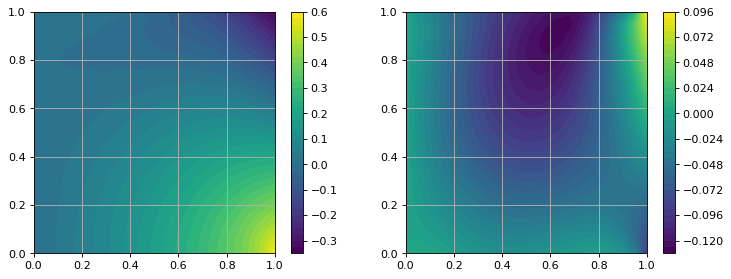

In [27]:
plt.figure(figsize = (11, 4), dpi = 80)
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.colorbar(plot(u[i])); plt.grid()

In [ ]:
# Save solution in VTK format
file = File("displacement.pvd");
file << u;